# Support Vector Machine for mortality prediction

### Importing necessary libraries

In [50]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import os
sns.set()
# Access data.
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
oversample = SMOTE()
scaler = StandardScaler()

## Load dataset

In [52]:
uploaded = files.upload()

Saving rawdata.csv to rawdata (3).csv


In [0]:
import io
icudata = pd.read_csv(io.BytesIO(uploaded['rawdata.csv']))

In [54]:
icudata

,age,height,weight,eyes,motor,verbal,GCSTotal,temperature,respiratoryrate,heartrate,glucose,O2,fio2,ph,los,SBP,DBP,MAP,ethnicity,gender,hosp_alive,icu_alive
0,81.0,165.1,61.70,4.0,6.0,5.0,15.0,34.8,5.0,114.0,185.0,95.0,60.0,7.390,10.893056,103.366634,55.650501,71.555879,1.0,1,0,0
1,59.0,180.3,92.30,4.0,6.0,5.0,15.0,37.2,10.0,114.0,121.0,98.0,21.0,6.700,10.679861,132.334862,57.155963,82.215596,1.0,0,0,0
2,80.0,170.2,103.30,4.0,6.0,5.0,15.0,36.6,55.0,102.0,273.0,97.0,21.0,6.700,3.610417,112.200000,59.900000,77.333333,1.0,0,0,0
3,63.0,183.0,118.00,4.0,6.0,5.0,15.0,37.3,26.0,100.0,143.0,97.0,60.0,7.450,2.949306,128.652968,60.463470,83.193303,1.0,0,0,0
4,60.0,165.1,79.90,4.0,6.0,4.0,14.0,34.5,37.0,137.0,273.0,99.0,40.0,7.070,3.611806,117.556477,62.197927,80.650777,1.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17888,51.0,180.3,59.00,4.0,6.0,3.0,13.0,34.5,26.0,56.0,192.0,92.0,100.0,7.444,11.053472,130.552042,67.630504,88.604350,3.0,0,0,0
17889,51.0,170.2,63.05,1.0,1.0,1.0,3.0,34.5,33.0,86.0,273.0,88.0,100.0,7.404,2.611111,115.167622,61.166189,79.166667,0.0,1,1,1
17890,66.0,157.5,71.50,4.0,6.0,3.0,13.0,35.8,50.0,115.0,209.0,81.0,100.0,7.494,29.383333,122.685241,49.463950,73.871047,1.0,1,0,0
17891,50.0,165.1,59.00,1.0,5.0,1.0,7.0,34.9,14.0,62.0,182.0,97.0,100.0,7.185,2.145833,134.452465,77.519366,96.497066,3.0,1,0,0


### Dropping any null values

In [55]:
icudata = icudata.dropna()
icudata = icudata.drop('icu_alive',axis=1)
icudata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17764 entries, 0 to 17892
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              17764 non-null  float64
 1   height           17764 non-null  float64
 2   weight           17764 non-null  float64
 3   eyes             17764 non-null  float64
 4   motor            17764 non-null  float64
 5   verbal           17764 non-null  float64
 6   GCSTotal         17764 non-null  float64
 7   temperature      17764 non-null  float64
 8   respiratoryrate  17764 non-null  float64
 9   heartrate        17764 non-null  float64
 10  glucose          17764 non-null  float64
 11  O2               17764 non-null  float64
 12  fio2             17764 non-null  float64
 13  ph               17764 non-null  float64
 14  los              17764 non-null  float64
 15  SBP              17764 non-null  float64
 16  DBP              17764 non-null  float64
 17  MAP         

## Splitting the dataset into training and testing data

In [56]:
feature_cols = ['age','height','weight','eyes','motor','verbal','GCSTotal','temperature','respiratoryrate','heartrate','glucose','O2','fio2','ph','los','SBP','DBP','MAP','ethnicity','gender']
x = icudata[feature_cols]
y = icudata.hosp_alive
x,y = oversample.fit_resample(x,y)
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,    #splitting 
                                                    test_size=0.25, 
                                                    random_state=0)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Feature Scaling

In [0]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Applying SVM model

In [0]:
modelsvm = SVC(kernel='linear',class_weight='balanced',probability=True)
modelsvm.fit(x_train,y_train)
predictionsvm = modelsvm.predict(x_test)
svmprob = modelsvm.predict_proba(x_test)

### Keeping probability of positive outcome only (i.e. expired patient)

In [0]:
svmprob = svmprob[:,1]

## Printing classification report

In [60]:
acc_svm = modelsvm.score(x_test, y_test)
print(classification_report(y_test,predictionsvm))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      3706
           1       0.71      0.72      0.72      3693

    accuracy                           0.71      7399
   macro avg       0.71      0.71      0.71      7399
weighted avg       0.71      0.71      0.71      7399



In [0]:
p = metrics.precision_score(y_test, predictionsvm)
r = metrics.recall_score(y_test, predictionsvm)
f1 = metrics.f1_score(y_test, predictionsvm)


In [0]:
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_test, svmprob)
auc_svm = metrics.roc_auc_score(y_test, svmprob)

In [0]:
precision2, recall2, _ = metrics.precision_recall_curve(y_test, svmprob)

In [64]:
print('*'*30)
print(f'Support Vector Machine results: \n')
print(f'\t Acc = {acc_svm:.3f} \n\t Precision={p:.3f} \n\t Recall={r:.3f} \n\t F1={f1:.3f} \n\t AUC={auc_svm:.3f} \n\t')

******************************
Support Vector Machine results: 

	 Acc = 0.713 
	 Precision=0.707 
	 Recall=0.725 
	 F1=0.716 
	 AUC=0.781 
	


## Confusion Matrix

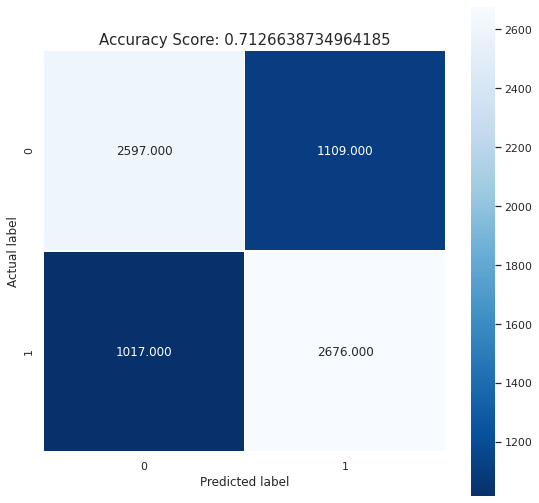

In [65]:
cm2 = metrics.confusion_matrix(y_test, predictionsvm)
plt.figure(figsize=(9,9))
sns.heatmap(cm2, annot=True, fmt=".3f", linewidths=.5, 
            square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);

## ROC Curve

Text(0.5, 1.0, 'ROC Curve, AUC = 0.781')

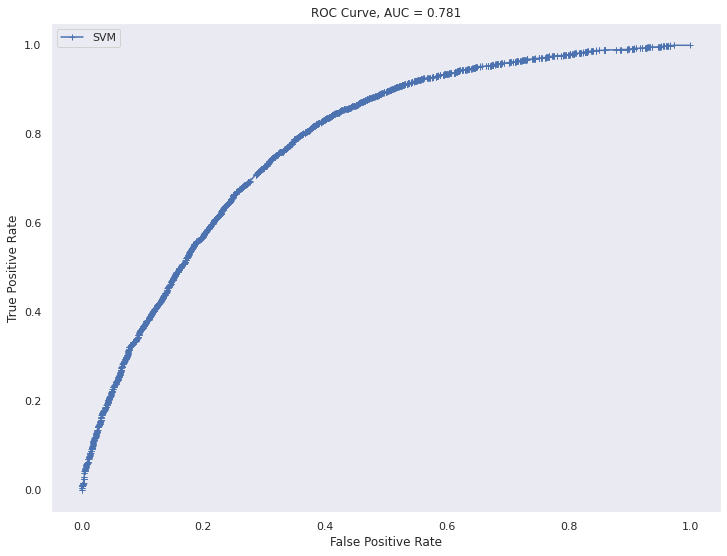

In [66]:
plt.figure(figsize=(12,9))
plt.plot(svm_fpr, svm_tpr, marker='+', label='SVM')
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.title(f'ROC Curve, AUC = {auc_svm:.3f}')

## Precision-Recall curve

Text(0.5, 1.0, 'Precision-Recall curve')

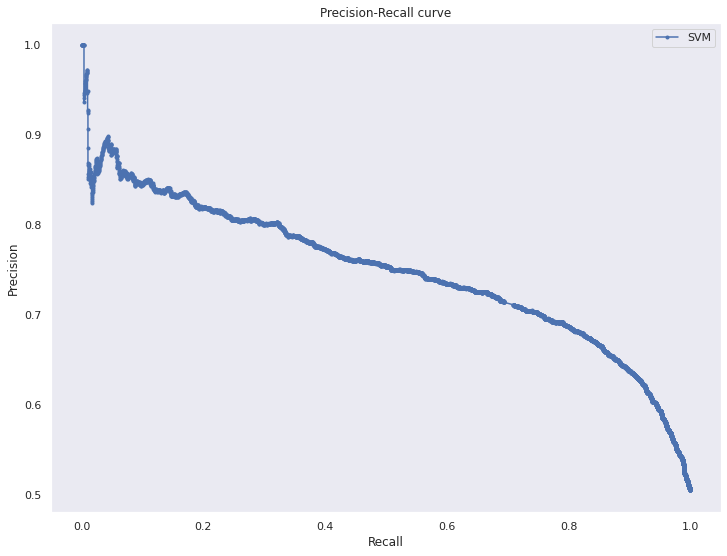

In [67]:
plt.figure(figsize=(12,9))
plt.plot(recall2, precision2, marker='.', label='SVM')
plt.grid()
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title(f'Precision-Recall curve')

## Cross evaluation of this model

Model evaluation for SVM 
 SVM - Accuracy result 0.6972905184241602 +/- 0.013362417799787595
 SVM - ROC_AUC result 0.7608229415305191 +/- 0.009537991896338955
 SVM - Precision result 0.688975942195544 +/- 0.014723128456539168
 SVM - Recall result 0.7196926377667284 +/- 0.008244129850658486


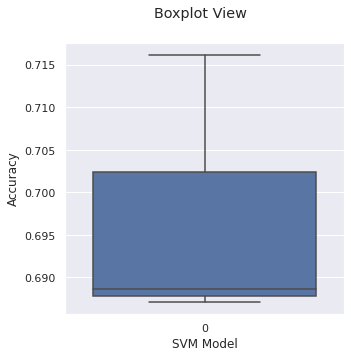

In [68]:
x = scaler.fit_transform(x)
print('Model evaluation for SVM ')
results = []
#kfold = model_selection.KFold(n_splits=1,random_state=7,shuffle=True)
cv_results = model_selection.cross_val_score(modelsvm,x,y,cv=3,scoring='accuracy',n_jobs=2)
cv_results2 = model_selection.cross_val_score(modelsvm,x,y,cv=3,scoring='roc_auc',n_jobs=2)
cv_results3 = model_selection.cross_val_score(modelsvm,x,y,cv=3,scoring='precision',n_jobs=2)
cv_results4 = model_selection.cross_val_score(modelsvm,x,y,cv=3,scoring='recall',n_jobs=2)
results.append(cv_results)
print(f' {name} - Accuracy result {cv_results.mean()} +/- {cv_results.std()}')
print(f' {name} - ROC_AUC result {cv_results2.mean()} +/- {cv_results2.std()}')
print(f' {name} - Precision result {cv_results3.mean()} +/- {cv_results3.std()}')
print(f' {name} - Recall result {cv_results4.mean()} +/- {cv_results4.std()}')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
plt.ylabel('Accuracy')
plt.xlabel('SVM Model')
plt.show()